In [1]:
import os

root_dir = r"/gpfs/home/pl2948/CV/Project"
os.makedirs(root_dir, exist_ok=True)

# Configuration (下半參數可動)

In [2]:
import os
import pandas as pd
import torch

csv_path = os.path.join(root_dir, "data", "metadata_2D.csv") 
metadata_2D_df = pd.read_csv(csv_path)

NUM_CLASSES_DETAILED = 12 # Detailed (12類): 0:BG, 1:SA, 2:RF, 3:VL, 4:VI, 5:VM, 6:AM, 7:GR, 8:BFL, 9:ST, 10:SM, 11:BFS
NUM_CLASSES_ROUGH = 5 # Rough (5類): 0:BG, 1:SA, 2:QF, 3:GR, 4:HS
TARGET_SIZE = (256, 256) #XY固定256X256，這項不能動
BATCH_SIZE = 16 #固定16，這項不能動

####以下參數可以自行調整####
ROUGH_LOSS_WEIGHT = 0.5
ORTHO_COUNDRY_WEIGHT = 2.0
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"資料總筆數: {len(metadata_2D_df)}")
print(f"Columns: {metadata_2D_df.columns.tolist()}")

資料總筆數: 13619
Columns: ['Dataset', 'MRI sample', 'Phenotype', 'Ethnicity', 'Gender', 'Age', 'MRI Sequence', 'Slice', 'image_2D_file', 'rough_label_2D_file', 'detailed_label_2D_file', 'split']


# Train - validation split (請勿更動)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 篩選出 Training Set
train_df = metadata_2D_df[metadata_2D_df['split'] == 'train'].copy()
has_detailed = train_df['detailed_label_2D_file'].notna()

train_detailed_df = train_df[has_detailed]
train_rough_only_df = train_df[~has_detailed]

print(f"原始 Train 總數: {len(train_df)}")
print(f"  - 有 Detailed Label: {len(train_detailed_df)}")
print(f"  - 只有 Rough Label: {len(train_rough_only_df)}")

# 從有 Detailed Label 的資料中，分層切分 Validation Set
train_det_subset, val_subset = train_test_split(
    train_detailed_df,
    test_size=0.1,  # 10% 用作驗證
    stratify=train_detailed_df['MRI Sequence'],
    random_state=42
)

final_train_df = pd.concat([train_rough_only_df, train_det_subset])

test_df = metadata_2D_df[metadata_2D_df['split'] == 'test'].copy()

print("-" * 30)
print(f"最終 Training Set: {len(final_train_df)} (混合 Rough + Detailed)")
print(f"最終 Validation Set: {len(val_subset)} (全為 Detailed)")
print(f"Test Set: {len(test_df)}")
print("-" * 30)
print("Validation Set 的 Sequence 分佈:")
print(val_subset['MRI Sequence'].value_counts())

原始 Train 總數: 12564
  - 有 Detailed Label: 5400
  - 只有 Rough Label: 7164
------------------------------
最終 Training Set: 12024 (混合 Rough + Detailed)
最終 Validation Set: 540 (全為 Detailed)
Test Set: 1055
------------------------------
Validation Set 的 Sequence 分佈:
MRI Sequence
T1       168
Fat      154
Water     78
T2        77
STIR      63
Name: count, dtype: int64


# Dataset 
(想加其他特徵可以調整dataset跟dataloader，但請不要動augmentation)

In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import SimpleITK as sitk
import numpy as np
import os
import pandas as pd
import cv2
import albumentations as A  # 引入資料增強庫

class MuscleTwoHeadDataset(Dataset):
    def __init__(self, dataframe, root_dir, target_size=(256, 256), augment=False):
        """
        Args:
            augment (bool): 是否開啟資料增強 (Training 時設為 True)
        """
        self.df = dataframe.reset_index(drop=True)
        # 注意：這裡保留您的設定，預設會在 root_dir 下多找一層 "data" 資料夾
        self.root_dir = os.path.join(root_dir, "data")
        self.target_size = target_size
        self.augment = augment

        self.transform_pipeline = A.Compose([
            A.Rotate(limit=15, p=0.5),      # 隨機旋轉 +/- 15度
            A.HorizontalFlip(p=0.5),        # 水平翻轉
            #A.VerticalFlip(p=0.1),          # 垂直翻轉 (比較少見但可增加難度)
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.2), # 隨機縮放與位移
        ])

    def __len__(self):
        return len(self.df)

    def preprocess_image(self, img):

        img = img.astype(np.float32)

        # 1. Percentile Clipping: 去除前 0.5% 極端值
        lower = np.percentile(img, 0.5)
        upper = np.percentile(img, 99.5)
        img = np.clip(img, lower, upper)

        # 2. Min-Max Scaling 到 0~1 之間
        if upper - lower > 0:
            img = (img - lower) / (upper - lower)
        else:
            img = img - lower # 避免除以零

        return img

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # --- 1. 讀取影像 (Image) ---
        # [路徑修正] 強制將 Windows 的反斜線 (\) 替換為 Linux 的正斜線 (/)
        img_rel_path = str(row['image_2D_file']).replace('\\', '/')
        img_path = os.path.join(self.root_dir, img_rel_path)

        if not os.path.exists(img_path):
             # 容錯：若找不到圖，回傳全黑，避免訓練中斷
            print(f"Warning: Image not found {img_path}")
            return torch.zeros(1, *self.target_size), torch.zeros(self.target_size).long(), -1, "Error"

        image_obj = sitk.ReadImage(img_path)
        image_np = sitk.GetArrayFromImage(image_obj).astype(np.float32) # (H, W)

        # [技術應用] 影像預處理 (Clipping + Normalize)
        image_np = self.preprocess_image(image_np)

        # 使用 OpenCV Resize (速度快且方便搭配 Albumentations)
        image_np = cv2.resize(image_np, self.target_size, interpolation=cv2.INTER_LINEAR)

        # --- 2. 讀取 Label (邏輯：優先使用 Detailed) ---
        label_np = None
        label_type = 0 # 1: Detailed, 0: Rough

        # 檢查是否有 Detailed Label
        if pd.notna(row['detailed_label_2D_file']):
            det_rel_path = str(row['detailed_label_2D_file']).replace('\\', '/')
            det_path = os.path.join(self.root_dir, det_rel_path)

            if os.path.exists(det_path):
                lbl_obj = sitk.ReadImage(det_path)
                label_np = sitk.GetArrayFromImage(lbl_obj).astype(np.int64)
                label_type = 1 # 標記為 Detailed

        # 如果沒有 Detailed，才去讀 Rough
        if label_np is None:
            rough_rel_path = str(row['rough_label_2D_file']).replace('\\', '/')
            rough_path = os.path.join(self.root_dir, rough_rel_path)

            if os.path.exists(rough_path):
                lbl_obj = sitk.ReadImage(rough_path)
                label_np = sitk.GetArrayFromImage(lbl_obj).astype(np.int64)
                label_type = 0 # 標記為 Rough
            else:
                # 如果都沒有，給全黑
                label_np = np.zeros(self.target_size, dtype=np.int64)
                label_type = -1

        # Resize Label (使用 Nearest Neighbor 保持類別整數)
        if label_np.shape != self.target_size:
            label_np = cv2.resize(label_np.astype(np.uint8), self.target_size, interpolation=cv2.INTER_NEAREST)

        # --- 3. [技術應用] 執行資料增強 (Augmentation) ---
        if self.augment:
            # Albumentations 需要 image 和 mask 一起傳入，確保旋轉角度一致
            augmented = self.transform_pipeline(image=image_np, mask=label_np)
            image_np = augmented['image']
            label_np = augmented['mask']

        # --- 4. 轉為 Tensor ---
        # Image: (H, W) -> (1, H, W)
        img_t = torch.from_numpy(image_np).float()
        if img_t.ndim == 2:
            img_t = img_t.unsqueeze(0)

        # Label: (H, W) -> LongTensor
        lbl_t = torch.from_numpy(label_np).long()

        return img_t, lbl_t, label_type, row['MRI sample']

In [2]:
from torch.utils.data import DataLoader

train_ds = MuscleTwoHeadDataset(final_train_df, root_dir, target_size=TARGET_SIZE,augment=True)
val_ds = MuscleTwoHeadDataset(val_subset, root_dir, target_size=TARGET_SIZE,augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

print("DataLoader 準備完成")

NameError: name 'final_train_df' is not defined

--- 檢查 Batch 數據與直方圖分布 ---
Images shape: torch.Size([16, 1, 256, 256])
Labels shape: torch.Size([16, 256, 256])
Types values: [1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]


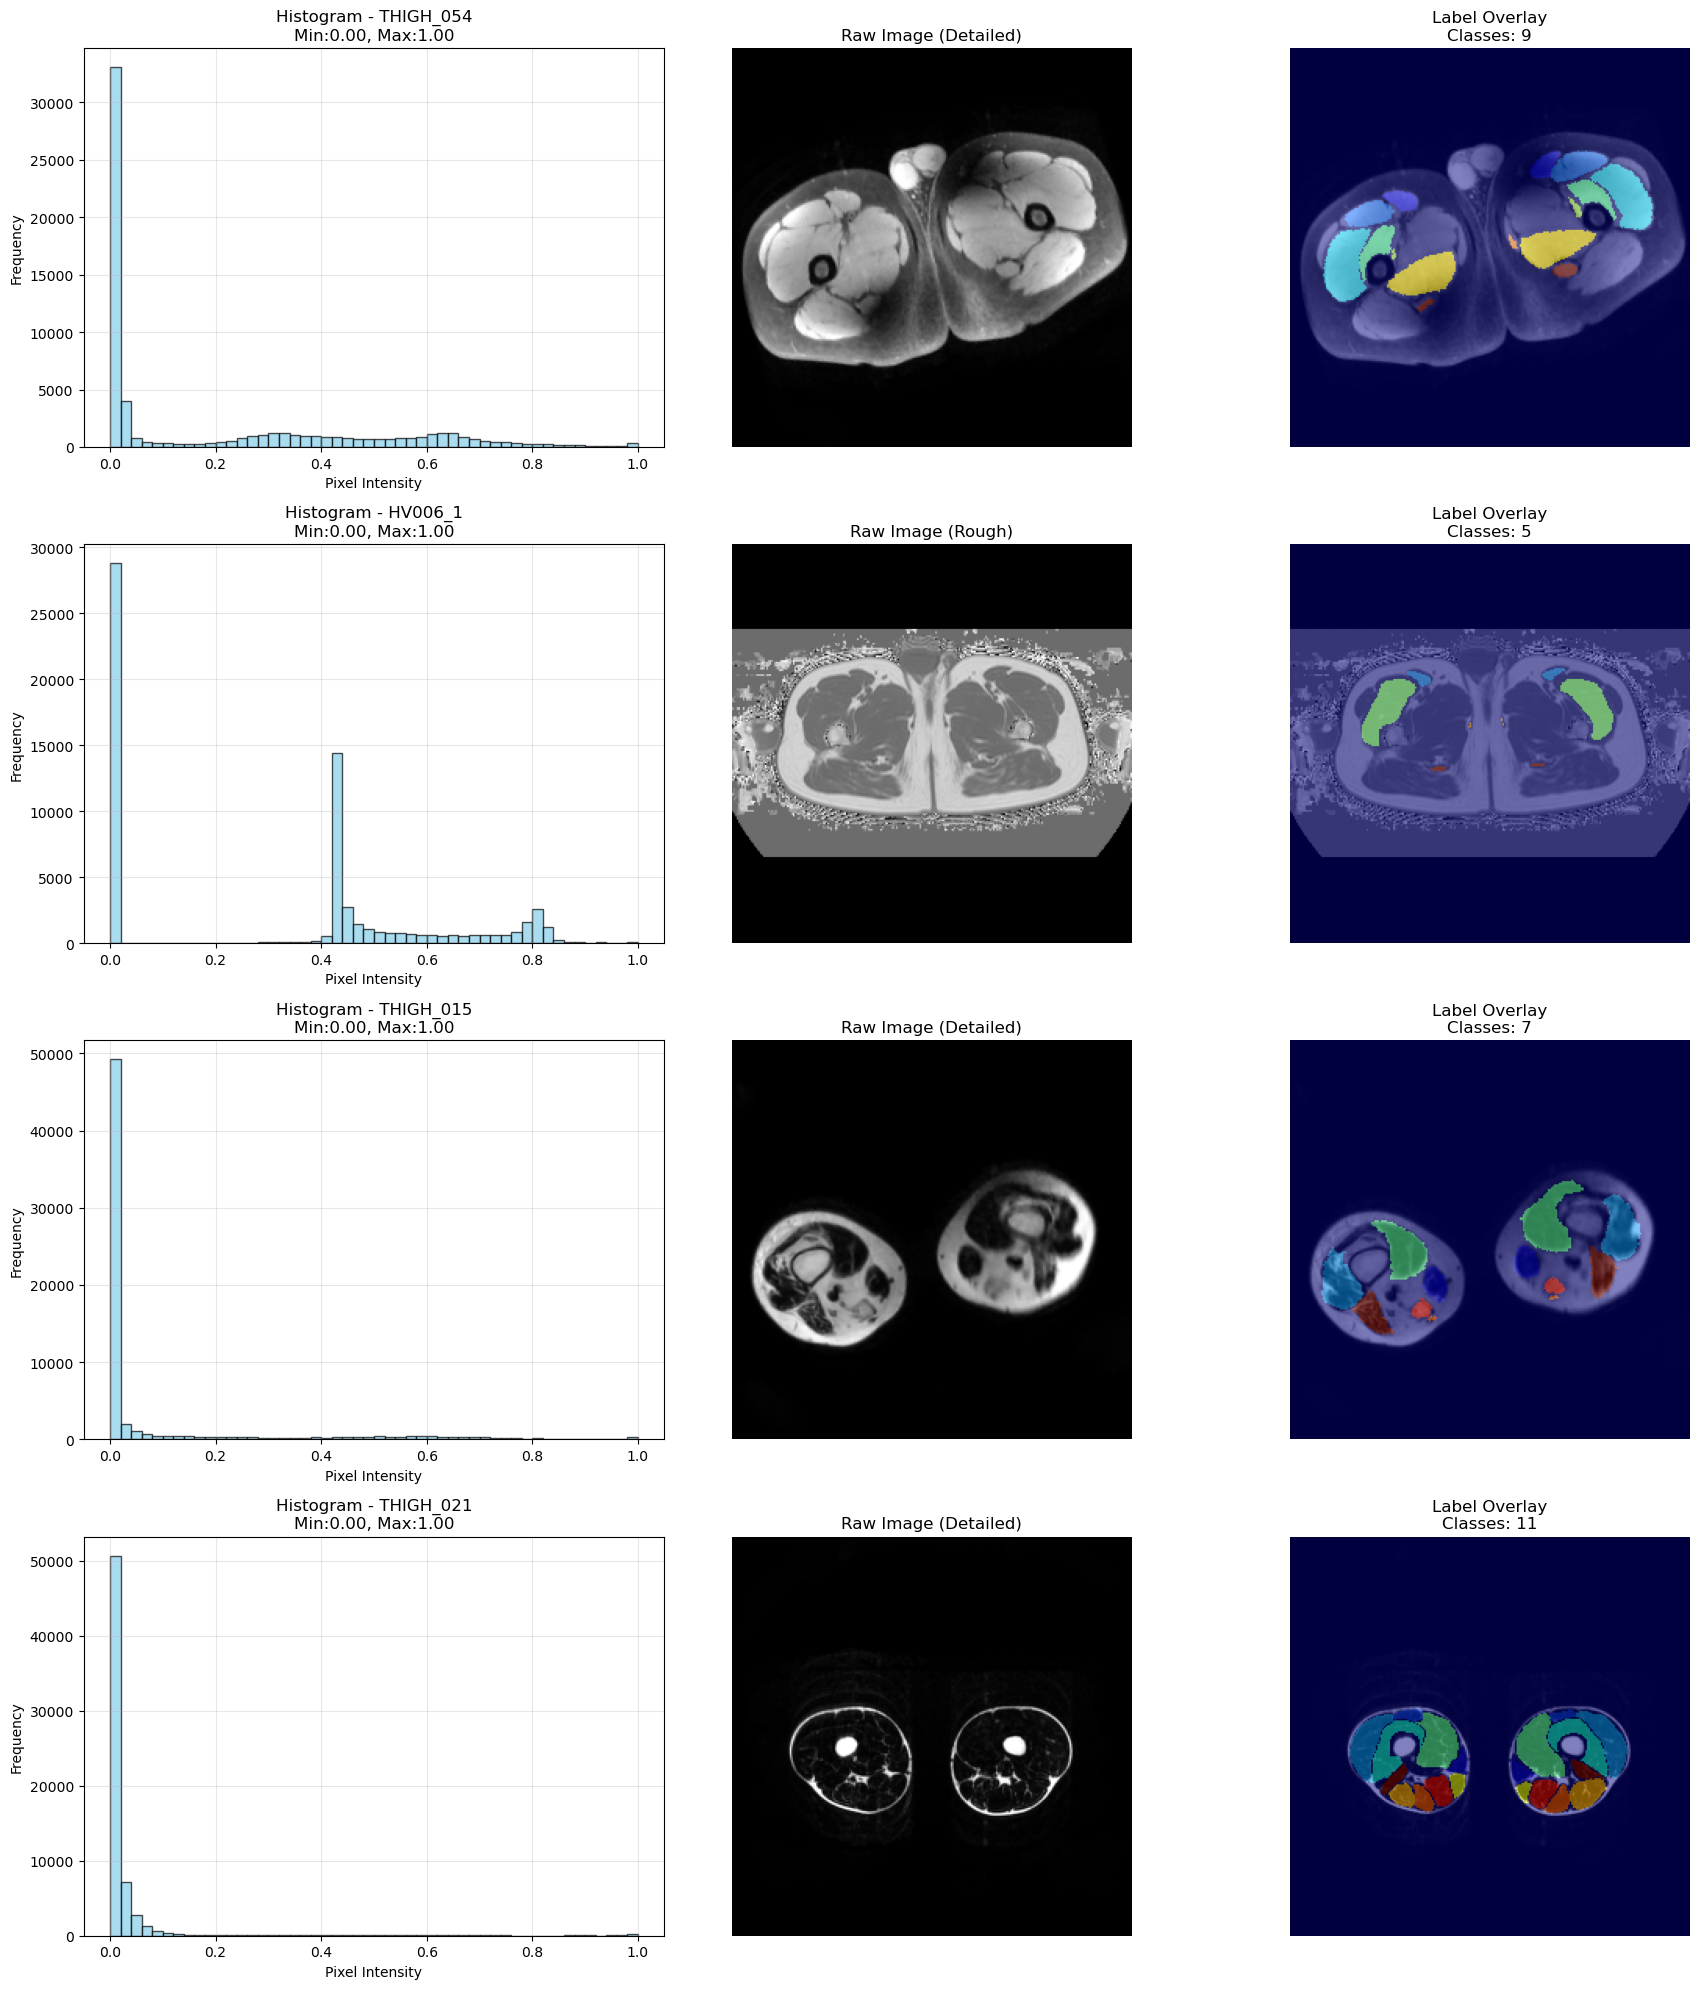


正在掃描 Train Loader ...


100%|██████████| 752/752 [02:50<00:00,  4.42it/s]


>> Train Loader 掃描完成！
   總樣本數: 12024
   全黑 Label 數: 0 (0.00%)
   沒有發現全黑的 Label。

正在掃描 Val Loader ...


100%|██████████| 540/540 [00:06<00:00, 77.64it/s]

>> Val Loader 掃描完成！
   總樣本數: 540
   全黑 Label 數: 0 (0.00%)
   沒有發現全黑的 Label。


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

NUM_TO_SHOW = 4  

print("--- 檢查 Batch 數據與直方圖分布 ---")
data_iter = iter(train_loader)

try:
    images, labels, types, sample_ids = next(data_iter)

    print(f"Images shape: {images.shape}")  # (B, 1, H, W)
    print(f"Labels shape: {labels.shape}")  # (B, H, W)
    print(f"Types values: {types.tolist()}") # 0: Rough, 1: Detailed
    
    # 確保不會超過 Batch Size
    actual_show = min(NUM_TO_SHOW, images.shape[0])
    
    # 建立畫布：Rows = 樣本數, Cols = 3 (Histogram, Image, Overlay)
    fig, axes = plt.subplots(actual_show, 3, figsize=(18, 5 * actual_show))
    
    # 如果只有一張圖，axes 會是 1D array，為了統一處理轉為 2D
    if actual_show == 1:
        axes = np.expand_dims(axes, 0)

    for idx in range(actual_show):
        # 1. 準備數據
        img_tensor = images[idx, 0]
        img_np = img_tensor.numpy()
        lbl_np = labels[idx].numpy()
        
        # 判斷類型
        type_str = "Detailed" if types[idx] == 1 else "Rough"
        sample_id = sample_ids[idx]
        
        # 檢查是否為空 Label
        unique_vals = np.unique(lbl_np)
        is_empty = (lbl_np.max() == 0)
        warning_txt = " (EMPTY!)" if is_empty else ""
        
        # --- 子圖 1: Histogram (最左邊) ---
        ax_hist = axes[idx, 0]
        # 把圖片拉平成一維陣列來畫直方圖
        ax_hist.hist(img_np.ravel(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
        ax_hist.set_title(f"Histogram - {sample_id}\nMin:{img_np.min():.2f}, Max:{img_np.max():.2f}")
        ax_hist.set_ylabel("Frequency")
        ax_hist.set_xlabel("Pixel Intensity")
        ax_hist.grid(True, alpha=0.3)
        
        # --- 子圖 2: 原始影像 (中間) ---
        ax_img = axes[idx, 1]
        ax_img.imshow(img_np, cmap='gray')
        ax_img.set_title(f"Raw Image ({type_str})")
        ax_img.axis('off')
        
        # --- 子圖 3: Label Overlay (最右邊) ---
        ax_ovl = axes[idx, 2]
        ax_ovl.imshow(img_np, cmap='gray')
        # 使用 jet colormap 並設定透明度
        ax_ovl.imshow(lbl_np, cmap='jet', alpha=0.5) 
        ax_ovl.set_title(f"Label Overlay{warning_txt}\nClasses: {len(unique_vals)}")
        ax_ovl.axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"繪圖過程中發生錯誤: {e}")
    # 印出詳細錯誤以便除錯
    import traceback
    traceback.print_exc()

# 2. 完整掃描與統計 (包含 Train 與 Val)
def scan_loader(loader, loader_name):
    print(f"\n正在掃描 {loader_name} ...")
    
    total_samples = 0
    empty_count = 0
    empty_samples = [] # 儲存全黑樣本的資訊

    try:
        for batch_idx, (images, labels, types, sample_ids) in enumerate(tqdm(loader)):
            
            # 遍歷 Batch 中的每一張圖
            batch_size = labels.shape[0]
            total_samples += batch_size
            
            for i in range(batch_size):
                # 判斷該張 Label 是否最大值為 0 (即全黑)
                if labels[i].max() == 0:
                    empty_count += 1
                    # 記錄下來 (只記前 10 筆以免刷屏，或者是全部存起來最後看)
                    if len(empty_samples) < 20: 
                        type_str = "Detailed" if types[i] == 1 else "Rough"
                        empty_samples.append(f"{sample_ids[i]} ({type_str})")

        print(f">> {loader_name} 掃描完成！")
        print(f"   總樣本數: {total_samples}")
        print(f"   全黑 Label 數: {empty_count} ({empty_count/total_samples*100:.2f}%)")
        
        if empty_count > 0:
            print("   部分全黑樣本 ID 範例:")
            for s in empty_samples:
                print(f"     - {s}")
            if empty_count > 20:
                print(f"     ... 以及其他 {empty_count - 20} 張")
        else:
            print("   沒有發現全黑的 Label。")

    except Exception as e:
        print(f"\n!! 錯誤：在 Batch {batch_idx} 發生錯誤 !!")
        print(f"錯誤訊息: {e}")

scan_loader(train_loader, "Train Loader")
scan_loader(val_loader, "Val Loader")

# Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class TwoHeadUNet(nn.Module):
    def __init__(self, n_channels, n_classes_detailed, n_classes_rough):
        super(TwoHeadUNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))
        
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        
        # === 兩個 Output Heads ===
        # Head 1: 負責 Detailed Label (12類)
        self.head_detailed = nn.Conv2d(64, n_classes_detailed, kernel_size=1)
        
        # Head 2: 負責 Rough Label (5類)
        self.head_rough = nn.Conv2d(64, n_classes_rough, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5)
        if x.shape != x4.shape: x = F.interpolate(x, size=x4.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)
        
        x = self.up2(x)
        if x.shape != x3.shape: x = F.interpolate(x, size=x3.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)
        
        x = self.up3(x)
        if x.shape != x2.shape: x = F.interpolate(x, size=x2.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)
        
        x = self.up4(x)
        if x.shape != x1.shape: x = F.interpolate(x, size=x1.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)
        
        # 輸出兩個結果
        out_detailed = self.head_detailed(x)
        out_rough = self.head_rough(x)
        
        return out_detailed, out_rough

model = TwoHeadUNet(n_channels=1, 
                    n_classes_detailed=NUM_CLASSES_DETAILED, # 12
                    n_classes_rough=NUM_CLASSES_ROUGH)       # 5
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
class DualTaskLoss(nn.Module):
    def __init__(self, rough_weight=0.5):
        """
        rough_weight: 控制 Rough Loss 的權重 (例如 0.5 表示粗標註的重要性是細標註的一半)
        """
        super().__init__()
        self.ce = nn.CrossEntropyLoss()
        self.rough_weight = rough_weight
        
    def forward(self, pred_detailed, pred_rough, targets, types):
        """
        pred_detailed: (B, 12, H, W)
        pred_rough:    (B, 5, H, W)
        targets:       (B, H, W) - 包含 0-11 或 0-4 的值
        types:         (B) - 1: Detailed, 0: Rough
        """
        total_loss = 0.0
        
        # === 1. 計算 Detailed Loss (只針對 types == 1) ===
        det_mask = (types == 1)
        if det_mask.any():
            # 取出 Detailed 的預測與 GT
            p_det = pred_detailed[det_mask]
            t_det = targets[det_mask]
            
            # CrossEntropy (Head_Detailed vs Detailed GT)
            loss_det = self.ce(p_det, t_det)
            total_loss += loss_det
            
        # === 2. 計算 Rough Loss (只針對 types == 0) ===
        rough_mask = (types == 0)
        if rough_mask.any():
            # 取出 Rough 的預測與 GT
            p_rough = pred_rough[rough_mask]
            t_rough = targets[rough_mask]
            
            # CrossEntropy (Head_Rough vs Rough GT)
            loss_rough = self.ce(p_rough, t_rough)
            
            # 乘上權重
            total_loss += loss_rough * self.rough_weight
            
        return total_loss

criterion = DualTaskLoss(rough_weight=ROUGH_LOSS_WEIGHT)

# Training

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm

best_val_dice = 0.0

train_loss_list = []
avg_val_dice_list = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, labels, types, _ in pbar:
        images, labels, types = images.to(DEVICE), labels.to(DEVICE), types.to(DEVICE)
        
        optimizer.zero_grad()
        
        # Model 輸出兩個結果
        out_det, out_rough = model(images)
        
        # Loss 自動判斷要用哪一個
        loss = criterion(out_det, out_rough, labels, types)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
        
    # --- Validation (只看 Detailed Head 的表現) ---
    model.eval()
    val_dice_sum = 0
    
    with torch.no_grad():
        for images, labels, types, _ in val_loader:
            # Validation 全是 Detailed data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            out_det, _ = model(images)
            preds = torch.argmax(out_det, dim=1)
            
            # 計算 Dice
            curr_dice = 0
            for c in range(1, NUM_CLASSES_DETAILED):
                inter = ((preds == c) & (labels == c)).sum().item()
                union = ((preds == c).sum() + (labels == c).sum()).item()
                if union > 0: curr_dice += 2 * inter / union
                elif union == 0: curr_dice += 1.0
            
            val_dice_sum += curr_dice / (NUM_CLASSES_DETAILED - 1)
            
    avg_val_dice = val_dice_sum / len(val_loader)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | Val Dice: {avg_val_dice:.4f}")
    train_loss_list.append(train_loss/len(train_loader))
    avg_val_dice_list.append(avg_val_dice)
    
    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(model.state_dict(), os.path.join(root_dir, "best_two_head_model.pth"))
        print("New Best Model Saved")
        
torch.save(model.state_dict(), os.path.join(root_dir, "last_two_head_model.pth"))
print("Last Model Saved")

# Test

測試集 (Detailed Only) 數量: 618
發現 Sequence 種類: ['Fat' 'T1' 'T2' 'Water' 'STIR']
預計視覺化切片數: 10 (每個 Sequence 各 2 張)


/gpfs/home/pl2948/.conda/envs/cv_project/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|██████████| 618/618 [00:10<00:00, 58.66it/s]


   各 MRI Sequence 分肌肉 Dice 評估表


,Fat,STIR,T1,T2,Water
Adductor Magnus,0.7399,0.6379,0.8575,0.7443,0.7126
Biceps Femoris LH,0.7439,0.6898,0.8765,0.7188,0.6981
Biceps Femoris SH,0.7801,0.7657,0.8677,0.7614,0.7265
Gracilis,0.7918,0.5877,0.8484,0.7703,0.7257
Rectus Femoris,0.7883,0.6331,0.8492,0.8012,0.7397
Sartorius,0.8073,0.6648,0.8886,0.8123,0.7472
Semimembranosus,0.6936,0.7118,0.8586,0.7283,0.6269
Semitendinosus,0.7130,0.6953,0.8280,0.7124,0.6511
Vastus Intermedius,0.7413,0.7656,0.8748,0.7750,0.7307
Vastus Lateralis,0.7915,0.7840,0.8850,0.8169,0.7665



   各 Sequence 視覺化 (每個 Sequence 兩位病患的中間切片)


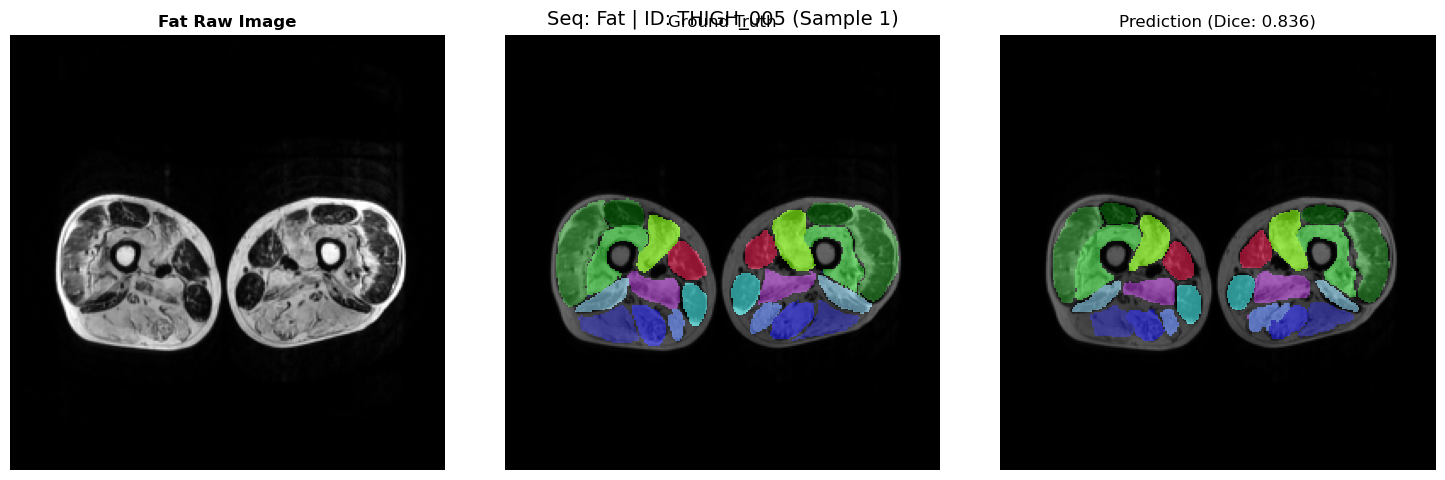

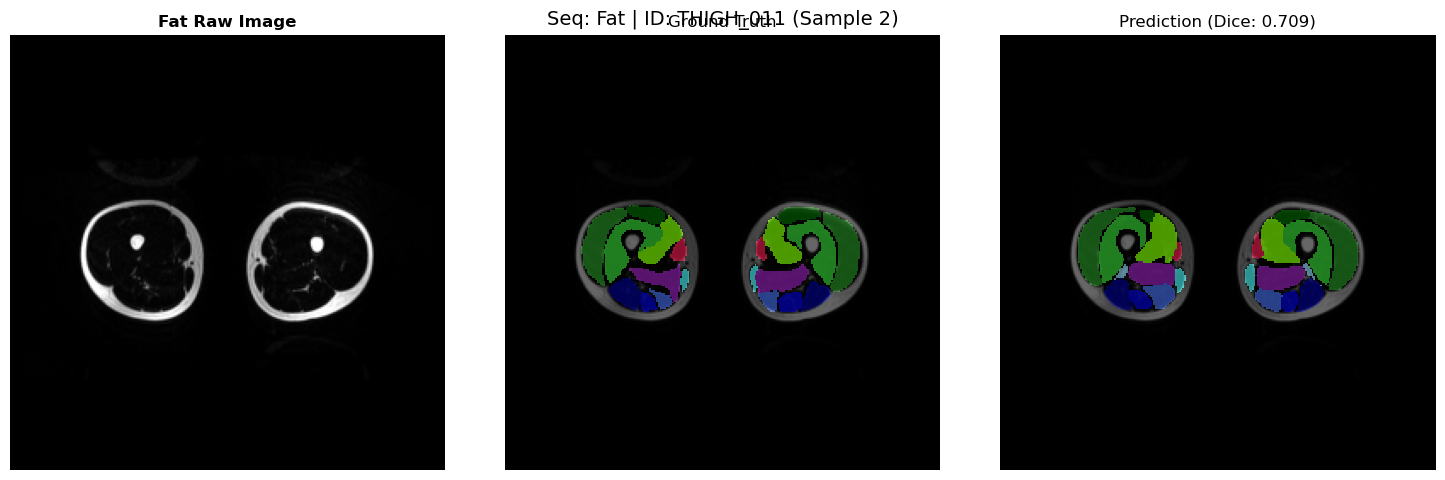

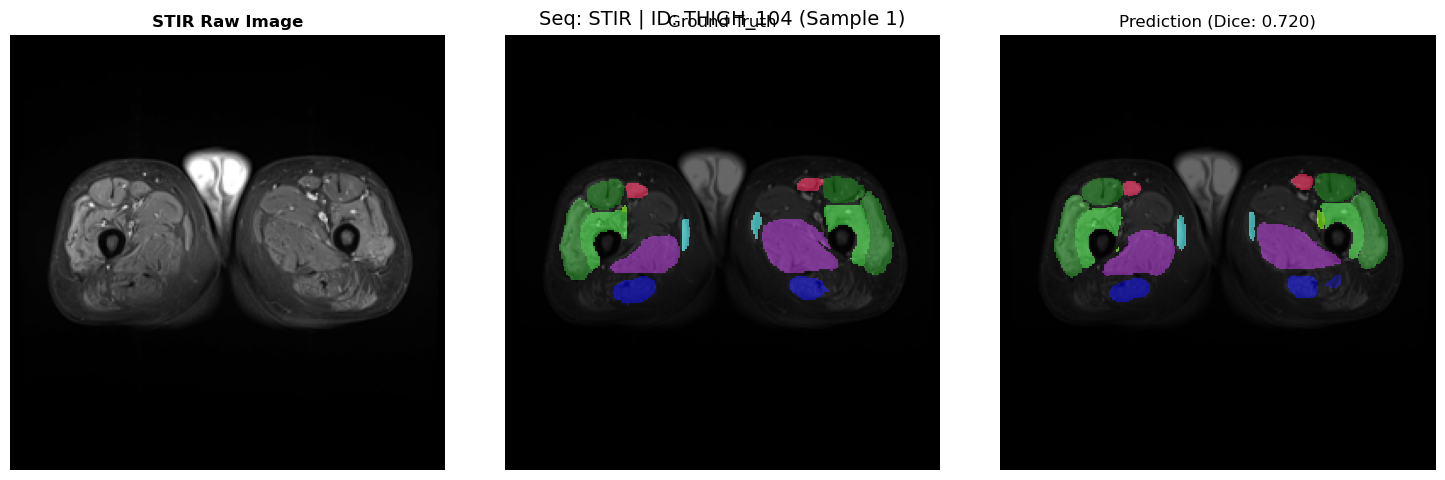

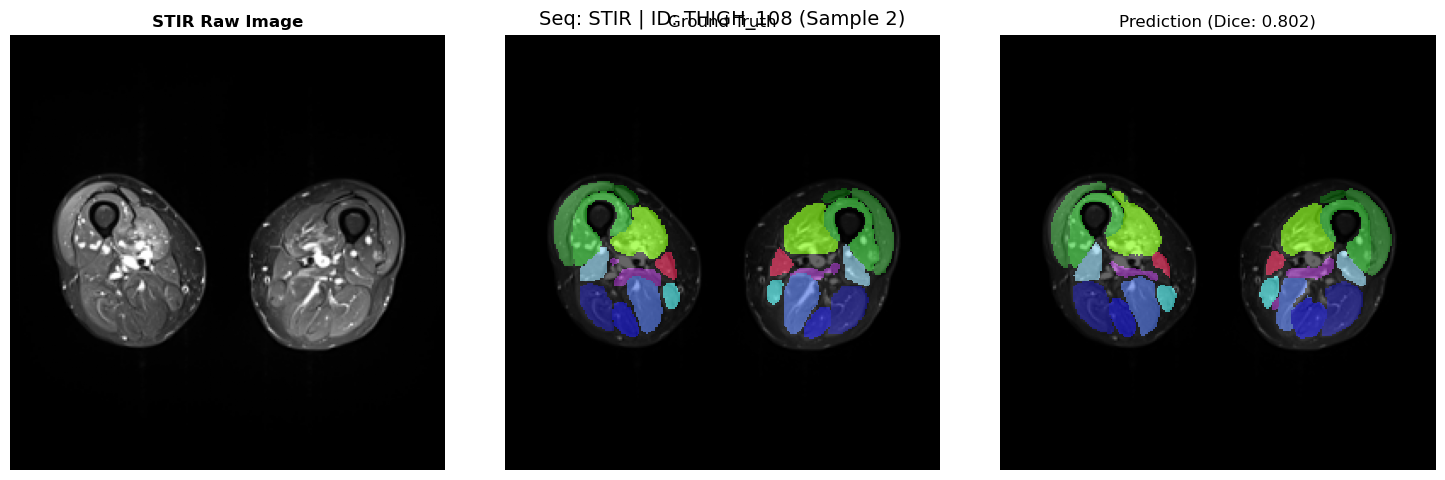

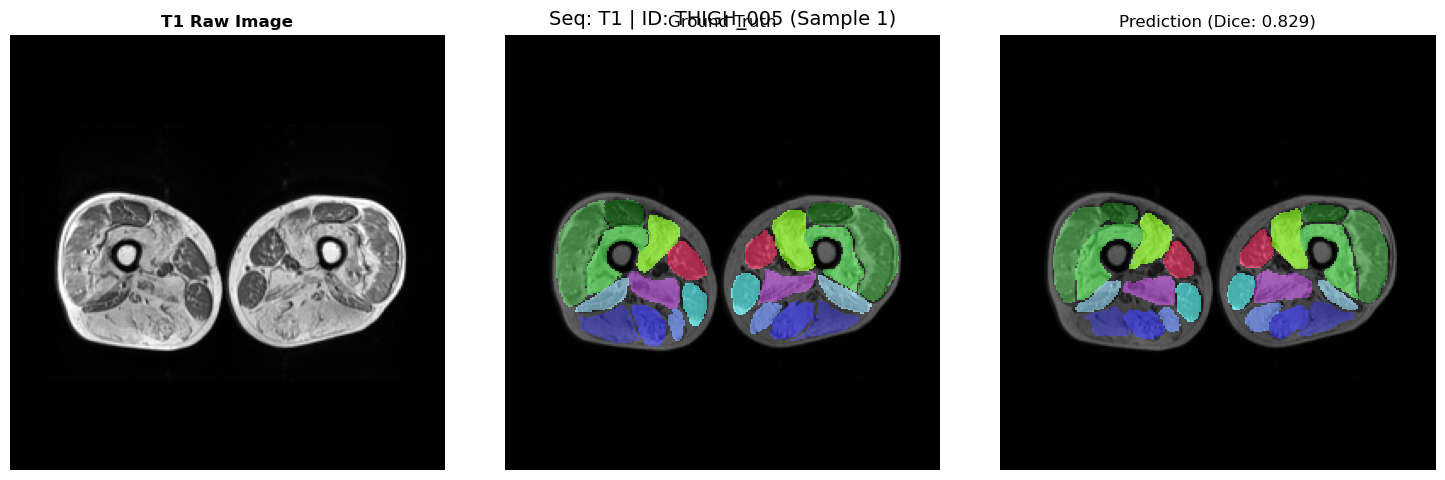

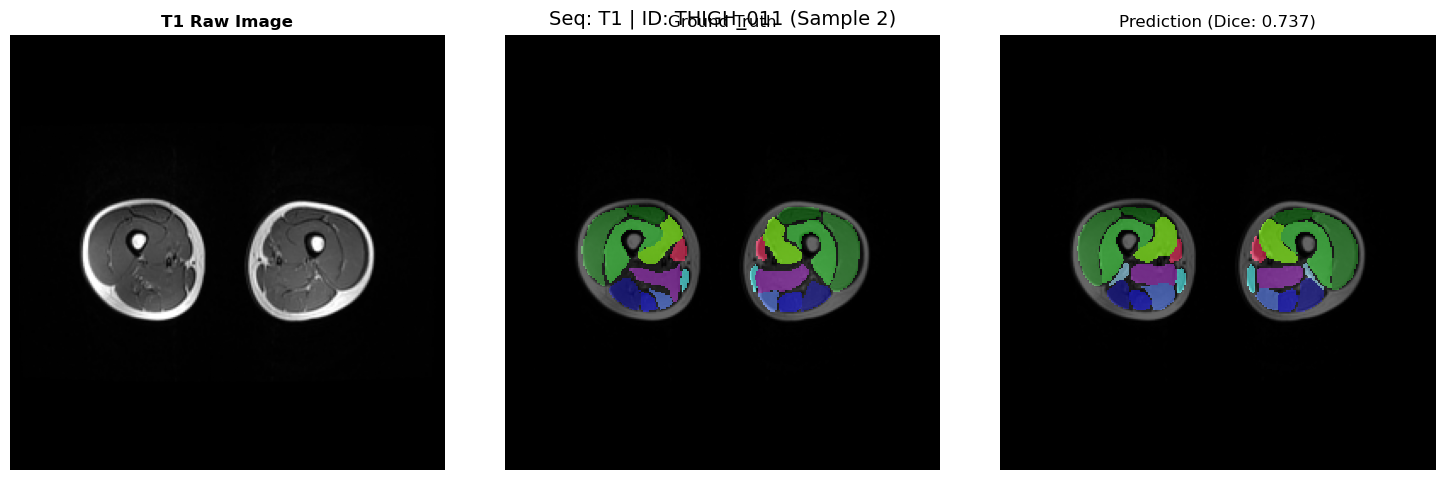

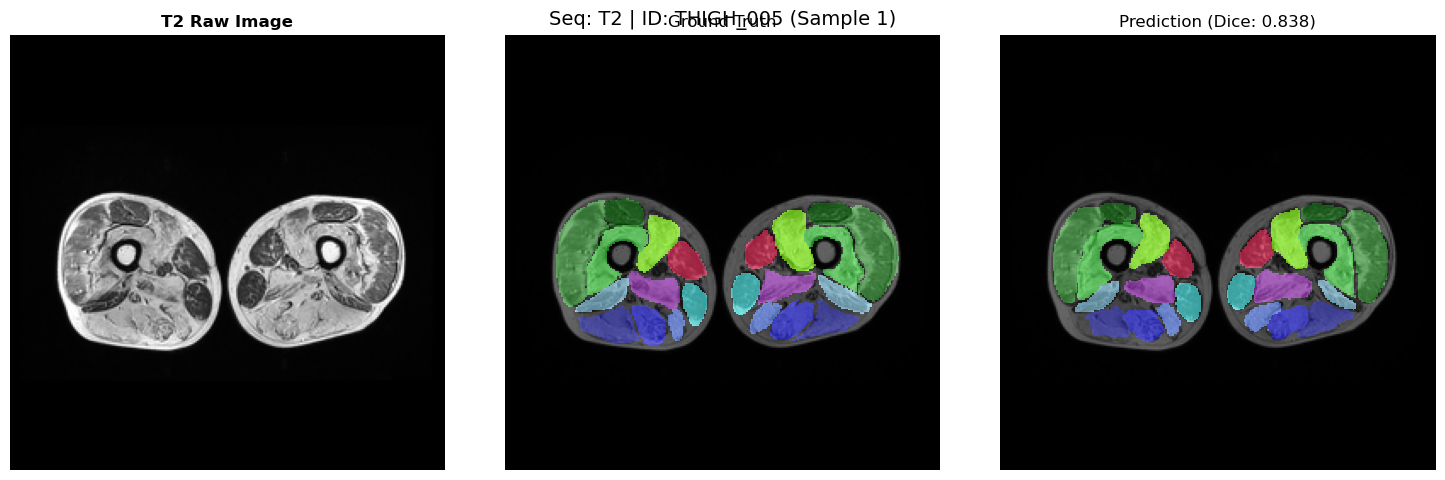

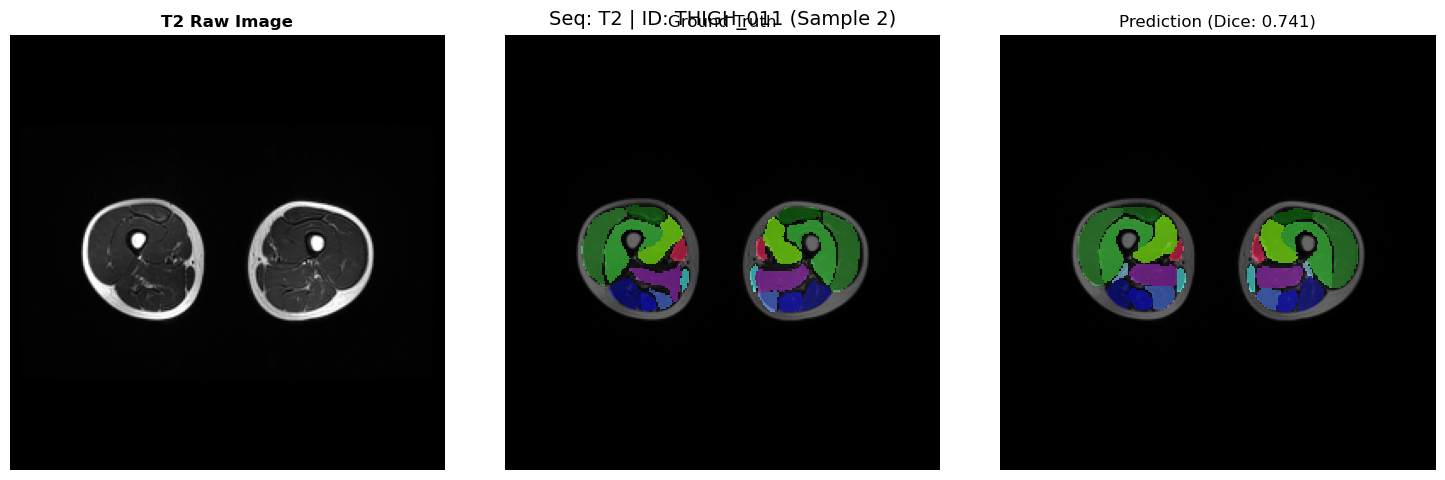

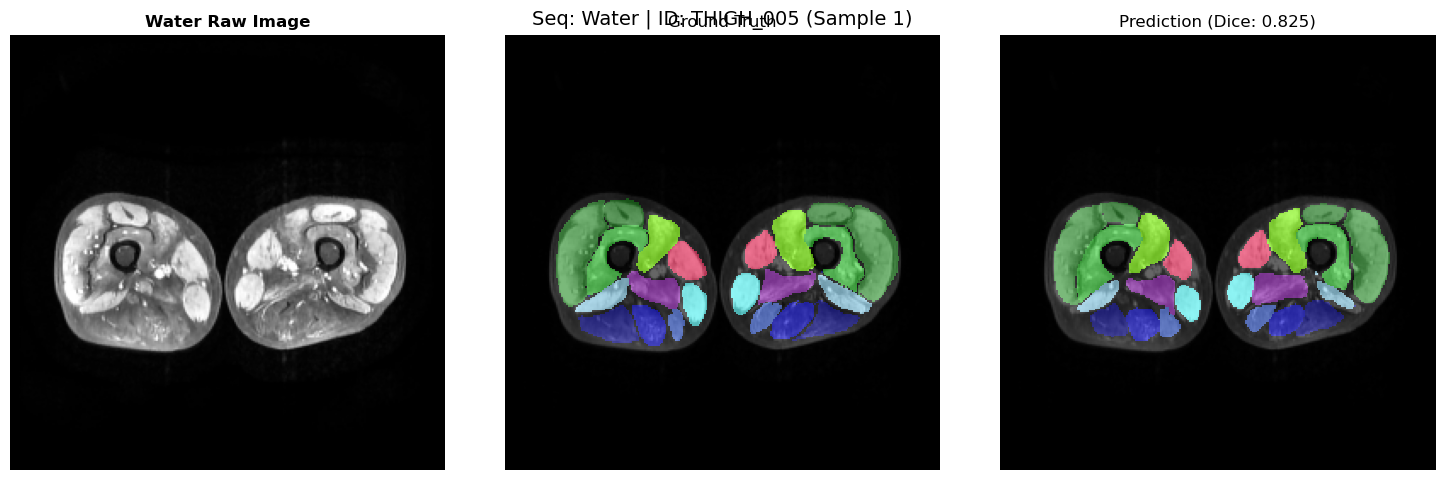

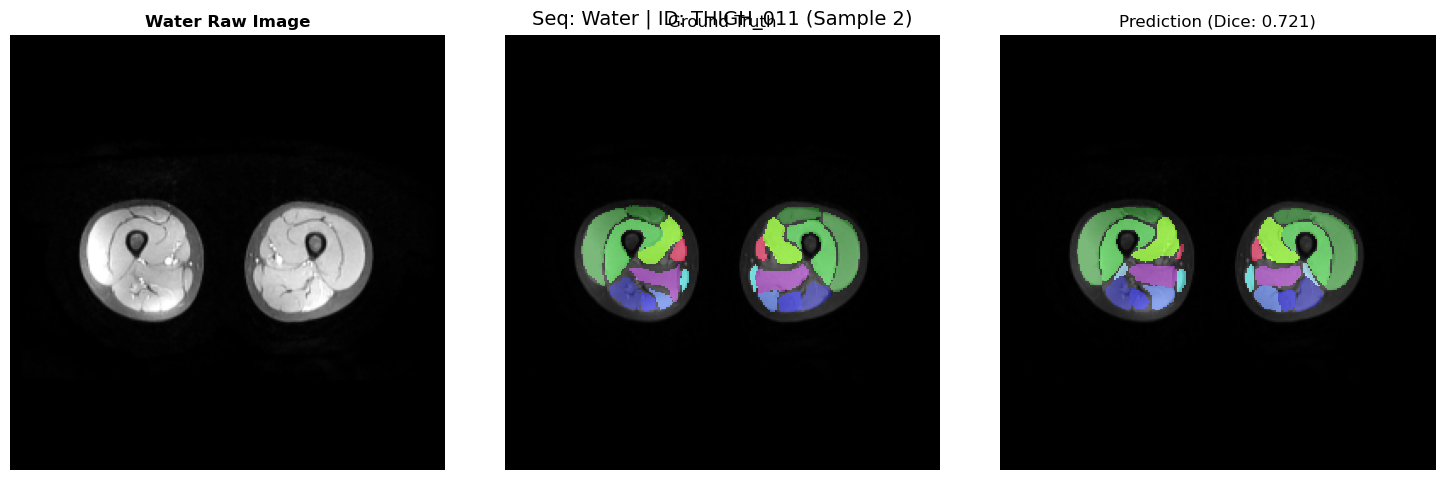

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import defaultdict
import os

# ================= Configuration =================
BATCH_SIZE = 1 
TARGET_SIZE = (256, 256)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = os.path.join(root_dir, "best_two_head_model.pth")

# 肌肉名稱對照表 (1-11)
MUSCLE_NAMES = {
    1: 'Sartorius',
    2: 'Rectus Femoris',
    3: 'Vastus Lateralis',
    4: 'Vastus Intermedius',
    5: 'Vastus Medialis',
    6: 'Adductor Magnus',
    7: 'Gracilis',
    8: 'Biceps Femoris LH',
    9: 'Semitendinosus',
    10: 'Semimembranosus',
    11: 'Biceps Femoris SH'
}

# 顏色表 (0-11)
colors = [
    '#000000', '#e6194b', '#006400', '#228B22', '#32CD32', '#7CFC00', 
    '#911eb4', '#46f0f0', '#00008B', '#0000CD', '#4169E1', '#87CEEB'
]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(13)-0.5, ncolors=12)

# ================= Configuration =================
BATCH_SIZE = 1 
TARGET_SIZE = (256, 256)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 肌肉名稱與顏色 (維持不變)
MUSCLE_NAMES = {1: 'Sartorius', 2: 'Rectus Femoris', 3: 'Vastus Lateralis', 
                4: 'Vastus Intermedius', 5: 'Vastus Medialis', 6: 'Adductor Magnus', 
                7: 'Gracilis', 8: 'Biceps Femoris LH', 9: 'Semitendinosus', 
                10: 'Semimembranosus', 11: 'Biceps Femoris SH'}
colors = ['#000000', '#e6194b', '#006400', '#228B22', '#32CD32', '#7CFC00', 
          '#911eb4', '#46f0f0', '#00008B', '#0000CD', '#4169E1', '#87CEEB']
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(13)-0.5, ncolors=12)

# ================= 1. 準備資料與鎖定視覺化目標 =================
# 確保資料排序正確
test_df = metadata_2D_df[metadata_2D_df['split'] == 'test'].copy()
test_detailed_df = test_df[test_df['detailed_label_2D_file'].notna()].copy()
test_detailed_df = test_detailed_df.sort_values(by=['MRI sample', 'MRI Sequence', 'Slice'])
test_detailed_df = test_detailed_df.reset_index(drop=True)

print(f"測試集 (Detailed Only) 數量: {len(test_detailed_df)}")

# --- 新的篩選邏輯：各 Sequence 取 2 個病患的中間張 ---
viz_indices = set()
viz_meta = {} # 用來存該 Index 對應的描述

# 取得所有出現的 Sequence
unique_sequences = test_detailed_df['MRI Sequence'].unique()
print(f"發現 Sequence 種類: {unique_sequences}")

for seq in unique_sequences:
    # 篩選出該 Sequence 的資料
    seq_df = test_detailed_df[test_detailed_df['MRI Sequence'] == seq]
    
    # 找出該 Sequence 下有哪些病患
    patients = seq_df['MRI sample'].unique()
    
    # 只取前 2 個病患 (如果不足2個則全取)
    target_patients = patients[:2]
    
    for pat in target_patients:
        # 找出該病患在該 Sequence 下的所有切片
        pat_df = seq_df[seq_df['MRI sample'] == pat]
        
        # 找出中間的那一張 index (local index -> global index)
        mid_idx_loc = len(pat_df) // 2
        global_idx = pat_df.index[mid_idx_loc]
        
        viz_indices.add(global_idx)
        # 紀錄一下是第幾個範例，方便標題顯示
        viz_meta[global_idx] = f"Sample {list(target_patients).index(pat) + 1}"

print(f"預計視覺化切片數: {len(viz_indices)} (每個 Sequence 各 2 張)")

# 建立 Dataset 與 Loader
test_ds = MuscleTwoHeadDataset(test_detailed_df, root_dir, target_size=TARGET_SIZE)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2)

# ================= 2. 載入模型  =================
model = TwoHeadUNet(n_channels=1, 
                    n_classes_detailed=NUM_CLASSES_DETAILED, 
                    n_classes_rough=NUM_CLASSES_ROUGH)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# ================= 3. 推論與數據收集 =================
metrics_data = defaultdict(lambda: defaultdict(list))
viz_results = [] 

with torch.no_grad():
    for idx, (images, labels, types, sample_ids) in enumerate(tqdm(test_loader)):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        row = test_detailed_df.iloc[idx]
        seq = row['MRI Sequence']
        sample_id = row['MRI sample']
        
        # 推論
        out_det, _ = model(images)
        pred_det = torch.argmax(out_det, dim=1)
        
        # 計算 Dice (維持原本邏輯以產生表格)
        for c in range(1, NUM_CLASSES_DETAILED):
            pred_mask = (pred_det == c)
            true_mask = (labels == c)
            inter = (pred_mask & true_mask).sum().item()
            union = (pred_mask.sum() + true_mask.sum()).item()
            dice_val = 2 * inter / union if union > 0 else 1.0
            metrics_data[seq][c].append(dice_val)
            
        # --- 收集視覺化資料 ---
        if idx in viz_indices:
            # 計算該張圖的平均 Dice 供顯示
            valid_dices = [metrics_data[seq][c][-1] for c in range(1, NUM_CLASSES_DETAILED)]
            avg_dice = sum(valid_dices) / len(valid_dices)
            
            viz_results.append({
                'sample': sample_id,
                'seq': seq,
                'img': images[0, 0].cpu().numpy(),
                'gt': labels[0].cpu().numpy(),
                'pred': pred_det[0].cpu().numpy(),
                'dice': avg_dice,
                'note': viz_meta[idx] # 例如 "Sample 1" 或 "Sample 2"
            })

# ================= 4. 產生報表 (維持不變) =================
print("\n" + "="*40)
print("   各 MRI Sequence 分肌肉 Dice 評估表")
print("="*40)
final_table = {}
all_sequences = sorted(metrics_data.keys())
for c in range(1, NUM_CLASSES_DETAILED):
    muscle_name = MUSCLE_NAMES[c]
    row_data = {}
    for seq in all_sequences:
        dices = metrics_data[seq][c]
        row_data[seq] = np.mean(dices) if dices else 0.0
    final_table[muscle_name] = row_data

df_metrics = pd.DataFrame(final_table).T
df_metrics = df_metrics.sort_index()
df_metrics.loc['AVERAGE'] = df_metrics.mean()
pd.options.display.float_format = '{:.4f}'.format
display(df_metrics)

# ================= 5. 視覺化展示 (修改處) =================
print("\n" + "="*40)
print("   各 Sequence 視覺化 (每個 Sequence 兩位病患的中間切片)")
print("="*40)

# 為了排版漂亮，我們先根據 Sequence 排序
viz_results.sort(key=lambda x: (x['seq'], x['note']))

for item in viz_results:
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # 標題顯示 Sequence, 病患ID, 以及 Dice 分數
    main_title = f"Seq: {item['seq']} | ID: {item['sample']} ({item['note']})"
    
    # 原圖
    axs[0].imshow(item['img'], cmap='gray')
    axs[0].set_title(f"{item['seq']} Raw Image", fontsize=12, fontweight='bold')
    axs[0].axis('off')
    
    # Ground Truth
    axs[1].imshow(item['img'], cmap='gray')
    axs[1].imshow(item['gt'], cmap=cmap, norm=norm, alpha=0.6, interpolation='nearest')
    axs[1].set_title("Ground Truth", fontsize=12)
    axs[1].axis('off')
    
    # Prediction
    axs[2].imshow(item['img'], cmap='gray')
    axs[2].imshow(item['pred'], cmap=cmap, norm=norm, alpha=0.6, interpolation='nearest')
    axs[2].set_title(f"Prediction (Dice: {item['dice']:.3f})", fontsize=12)
    axs[2].axis('off')
    
    plt.suptitle(main_title, fontsize=14, y=0.95)
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import os 

df_metrics = pd.read_csv(os.path.join(root_dir, "evaluation_metrics_per_sequence.csv"), index_col=0)

print(df_metrics.index)

avg_row = df_metrics.loc[['AVERAGE']]

other_rows = df_metrics.drop('AVERAGE')

df_metrics = pd.concat([avg_row, other_rows])

flat = df_metrics.stack()  # 變成 MultiIndex Series (row, col)
flat.index = [f"{row}_{col}" for row, col in flat.index]  # 合併名稱
flat_df = flat.to_frame().T  # 轉成一列 DataFrame

flat_df.to_csv(os.path.join(root_dir, "flattened_metrics.csv"), index=False)

Index(['Adductor Magnus', 'Biceps Femoris LH', 'Biceps Femoris SH', 'Gracilis',
       'Rectus Femoris', 'Sartorius', 'Semimembranosus', 'Semitendinosus',
       'Vastus Intermedius', 'Vastus Lateralis', 'Vastus Medialis', 'AVERAGE'],
      dtype='object')


# Clustering disease

/gpfs/home/pl2948/.conda/envs/cv_project/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Preparing data...
Total slices for ['T1', 'Fat'] combined: 402
Extracting muscle intensities from combined sequences...


100%|██████████| 402/402 [00:05<00:00, 76.68it/s]



Running PCA...
Feature Matrix Shape: (10, 11) (Patients x Muscles)
Explained Variance: PC1=0.78, PC2=0.14


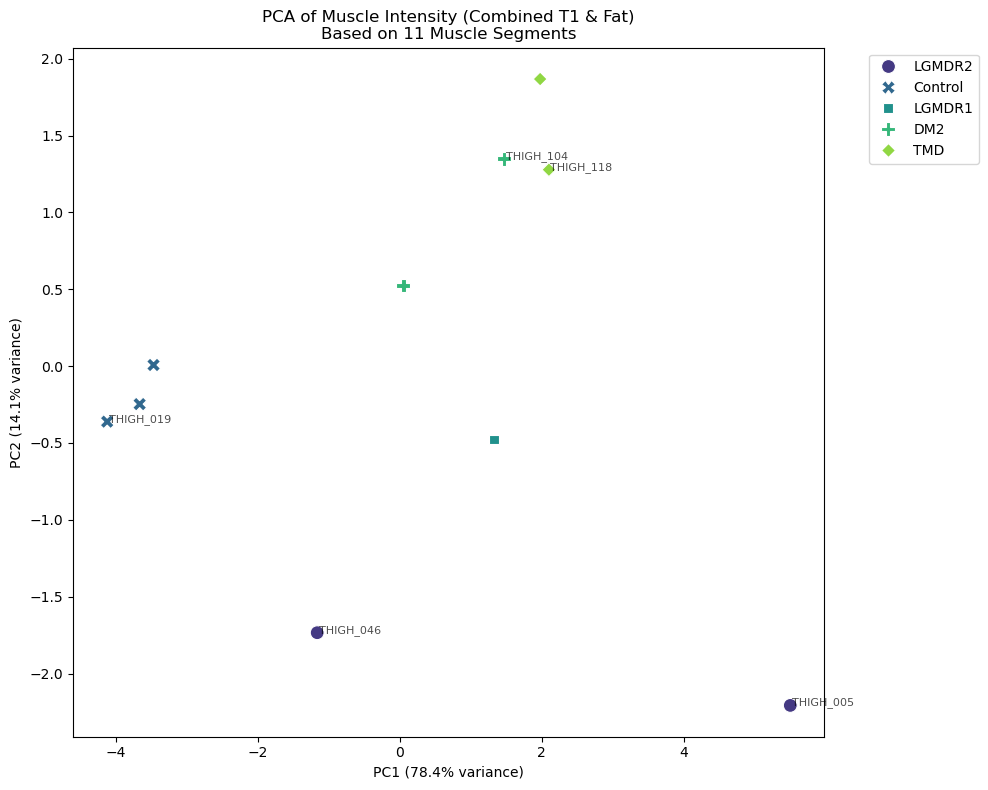

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # 使用新版 Imputer
import matplotlib.pyplot as plt
import seaborn as sns

# ================= Configuration =================
# 指定要合併分析的 Sequence 類別
TARGET_SEQUENCES = ['T1', 'Fat'] 
MUSCLE_INDICES = range(1, 12)

# ================= Data Preparation =================
print("Preparing data...")

# 1. 確保 Phenotype 欄位存在 (若無則嘗試從 metadata 補上)
if 'Phenotype' not in test_detailed_df.columns:
    if 'metadata_df' in locals():
        print("Mapping Phenotype from metadata_df...")
        pheno_map = metadata_df.set_index('MRI sample')['Phenotype'].to_dict()
        test_detailed_df['Phenotype'] = test_detailed_df['MRI sample'].map(pheno_map)
    else:
        print("Warning: 'metadata_df' not found. Phenotype will be 'Unknown'.")
        test_detailed_df['Phenotype'] = 'Unknown'

# 2. 篩選出 T1 和 Fat 的資料，並合併處理
# 這裡使用 isin() 來同時選取兩種 Sequence
combined_df = test_detailed_df[test_detailed_df['MRI Sequence'].isin(TARGET_SEQUENCES)].copy()
combined_df = combined_df.sort_values(by=['MRI sample', 'Slice']).reset_index(drop=True)

print(f"Total slices for {TARGET_SEQUENCES} combined: {len(combined_df)}")

if len(combined_df) > 0:
    # ================= Feature Extraction =================
    # 建立 Dataset 與 Loader
    # 假設 MuscleTwoHeadDataset 類別已經定義
    dataset = MuscleTwoHeadDataset(combined_df, root_dir, target_size=TARGET_SIZE)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

    # 統計變數: patient_stats[sample_id][muscle_id] = {'sum': ..., 'count': ...}
    # 用來累加該病患在所有切片(包含 T1 & Fat)中的像素值總和與數量
    patient_stats = defaultdict(lambda: defaultdict(lambda: {'sum': 0.0, 'count': 0}))
    patient_phenotypes = {}

    print("Extracting muscle intensities from combined sequences...")
    with torch.no_grad():
        for idx, (images, labels, _, _) in enumerate(tqdm(loader)):
            # 取得 meta info
            row = combined_df.iloc[idx]
            sample_id = row['MRI sample']
            phenotype = row.get('Phenotype', 'Unknown')
            patient_phenotypes[sample_id] = phenotype

            # 處理影像與 Label
            # 修正維度: img (1, 1, 256, 256) -> (1, 256, 256) 以匹配 label
            img = images.to(DEVICE).squeeze(1)
            lbl = labels.to(DEVICE)

            # 計算每個肌肉區域的亮度總和與像素數
            for m_id in MUSCLE_INDICES:
                mask = (lbl == m_id)
                # 只有當該切片包含該肌肉時才計算
                if mask.sum() > 0:
                    pixels = img[mask]
                    p_sum = pixels.sum().item()
                    p_count = pixels.numel()

                    patient_stats[sample_id][m_id]['sum'] += p_sum
                    patient_stats[sample_id][m_id]['count'] += p_count

    # ================= PCA Analysis =================
    print("\nRunning PCA...")

    # 建立特徵矩陣 (Rows: Patients, Cols: 11 Muscles)
    unique_patients = sorted(patient_stats.keys())
    feature_matrix = []
    phenotype_labels = []

    for pid in unique_patients:
        p_vec = []
        for m_id in MUSCLE_INDICES:
            stats = patient_stats[pid][m_id]
            if stats['count'] > 0:
                # 計算全域平均亮度 (Global Mean Intensity)
                mean_val = stats['sum'] / stats['count']
                p_vec.append(mean_val)
            else:
                p_vec.append(np.nan) # 缺失值 (該病患在任何切片都沒切到這條肌肉)
        
        feature_matrix.append(p_vec)
        phenotype_labels.append(patient_phenotypes[pid])

    X = np.array(feature_matrix)
    print(f"Feature Matrix Shape: {X.shape} (Patients x Muscles)")

    # 缺失值填補 (使用平均值)
    if np.isnan(X).all(axis=0).any():
        # 如果極端情況下某條肌肉完全沒數據，補 0
        imputer = SimpleImputer(strategy='constant', fill_value=0)
    else:
        imputer = SimpleImputer(strategy='mean')
    
    X_imputed = imputer.fit_transform(X)

    # 標準化 (Standardization)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # PCA 降維
    n_components = min(2, len(unique_patients), X_scaled.shape[1])
    if n_components >= 2:
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        
        explained_var = pca.explained_variance_ratio_
        print(f"Explained Variance: PC1={explained_var[0]:.2f}, PC2={explained_var[1]:.2f}")

        # ================= Visualization =================
        plot_df = pd.DataFrame({
            'PC1': X_pca[:, 0],
            'PC2': X_pca[:, 1],
            'Phenotype': phenotype_labels,
            'SampleID': unique_patients
        })

        plt.figure(figsize=(10, 8))
        # 使用 hue 來依據 Phenotype 上色
        sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Phenotype', style='Phenotype', s=100, palette='viridis')

        # 標示 Sample ID (間隔標示避免擁擠)
        for i in range(len(plot_df)):
            if i % 2 == 0:
                plt.text(plot_df.PC1[i]+0.02, plot_df.PC2[i], plot_df.SampleID[i], fontsize=8, alpha=0.7)

        plt.title('PCA of Muscle Intensity (Combined T1 & Fat)\nBased on 11 Muscle Segments')
        plt.xlabel(f'PC1 ({explained_var[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({explained_var[1]:.1%} variance)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    else:
        print("Not enough data for 2D PCA.")
else:
    print("No T1 or Fat data found in the dataset.")

/gpfs/home/pl2948/.conda/envs/cv_project/lib/python3.10/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Preparing combined dataset (Train + Test)...
Target Sequences: ['Fat', 'T1', 'FAT', 'FATFRACTION']
Total slices found: 3626
Unique patients: 93
Extracting muscle intensities...


100%|██████████| 3626/3626 [00:45<00:00, 80.14it/s] 



Running PCA...
Feature Matrix Shape: (93, 11) (Patients x Muscles)
Explained Variance: PC1=0.75, PC2=0.12


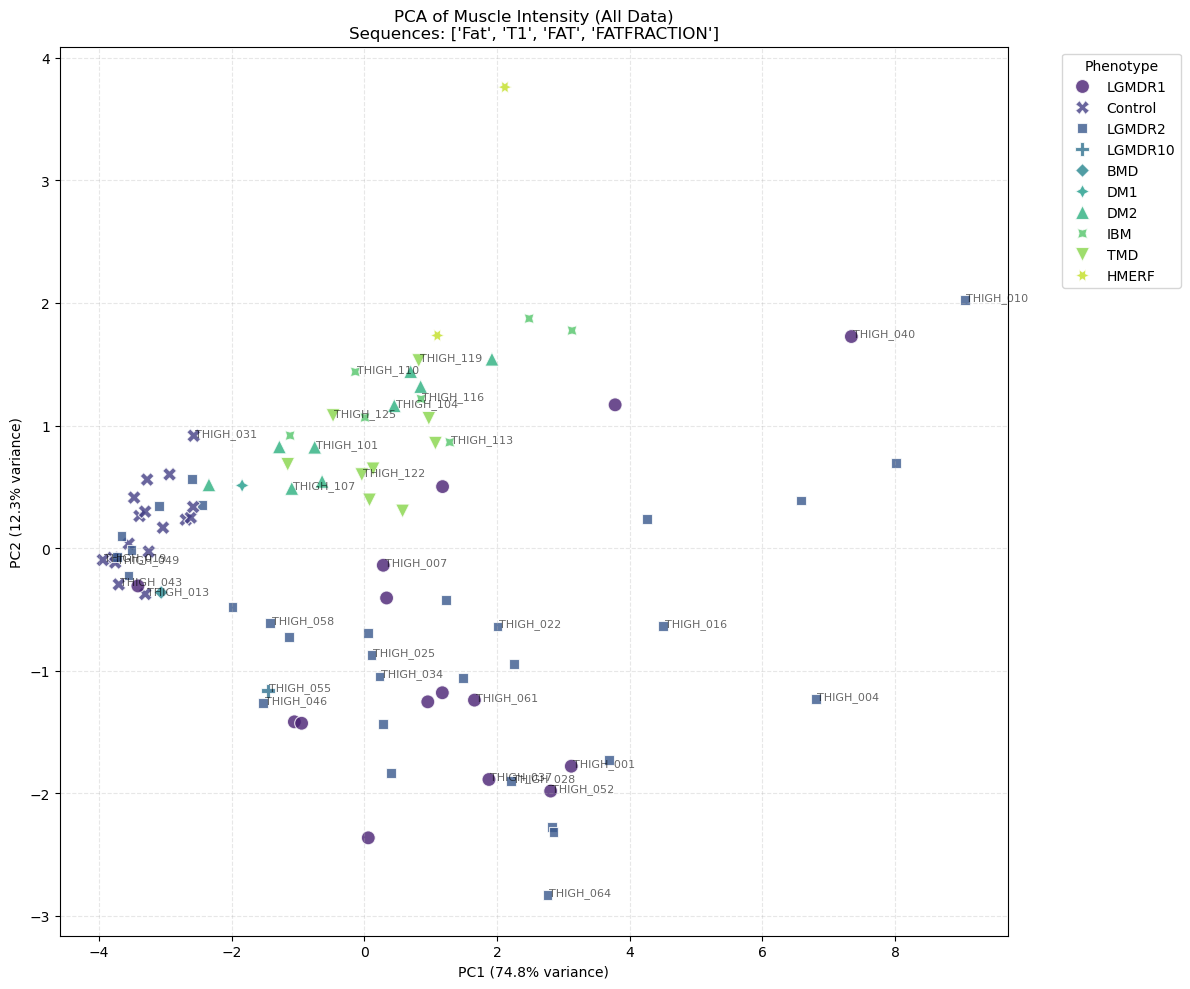


Top Contributing Muscles to PC1:
Muscle 4   0.3341
Muscle 3   0.3280
Muscle 5   0.3240
Muscle 9   0.3184
Muscle 2   0.3138
dtype: float64


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# ================= Configuration =================
# 1. 指定擴充後的 Sequence 列表
TARGET_SEQUENCES = ['Fat', 'T1', 'FAT', 'FATFRACTION']
MUSCLE_INDICES = range(1, 12)

# ================= Data Preparation =================
print("Preparing combined dataset (Train + Test)...")

# 1. 使用完整的 metadata_2D_df (不分 split)
# 確保只取有 segmentation label 的資料
if 'detailed_label_2D_file' in metadata_2D_df.columns:
    full_df = metadata_2D_df[metadata_2D_df['detailed_label_2D_file'].notna()].copy()
else:
    # 防呆：如果欄位名稱不同，請自行調整
    full_df = metadata_2D_df.copy()

# 2. 確保 Phenotype 欄位存在
if 'Phenotype' not in full_df.columns:
    if 'metadata_df' in locals():
        print("Mapping Phenotype from metadata_df...")
        pheno_map = metadata_df.set_index('MRI sample')['Phenotype'].to_dict()
        full_df['Phenotype'] = full_df['MRI sample'].map(pheno_map)
    else:
        print("Warning: 'metadata_df' not found. Phenotype will be 'Unknown'.")
        full_df['Phenotype'] = 'Unknown'

# 3. 篩選出目標 Sequence
combined_df = full_df[full_df['MRI Sequence'].isin(TARGET_SEQUENCES)].copy()
combined_df = combined_df.sort_values(by=['MRI sample', 'Slice']).reset_index(drop=True)

print(f"Target Sequences: {TARGET_SEQUENCES}")
print(f"Total slices found: {len(combined_df)}")
print(f"Unique patients: {combined_df['MRI sample'].nunique()}")

if len(combined_df) > 0:
    # ================= Feature Extraction =================
    # 建立 Dataset 與 Loader
    dataset = MuscleTwoHeadDataset(combined_df, root_dir, target_size=TARGET_SIZE)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

    # patient_stats[sample_id][muscle_id] = {'sum': ..., 'count': ...}
    patient_stats = defaultdict(lambda: defaultdict(lambda: {'sum': 0.0, 'count': 0}))
    patient_phenotypes = {}

    print("Extracting muscle intensities...")
    with torch.no_grad():
        for idx, (images, labels, _, _) in enumerate(tqdm(loader)):
            row = combined_df.iloc[idx]
            sample_id = row['MRI sample']
            phenotype = row.get('Phenotype', 'Unknown')
            patient_phenotypes[sample_id] = phenotype

            # 處理影像與 Label
            img = images.to(DEVICE).squeeze(1) # (1, H, W)
            lbl = labels.to(DEVICE)

            # 計算每個肌肉區域的亮度
            for m_id in MUSCLE_INDICES:
                mask = (lbl == m_id)
                if mask.sum() > 0:
                    pixels = img[mask]
                    p_sum = pixels.sum().item()
                    p_count = pixels.numel()

                    patient_stats[sample_id][m_id]['sum'] += p_sum
                    patient_stats[sample_id][m_id]['count'] += p_count

    # ================= PCA Analysis =================
    print("\nRunning PCA...")

    unique_patients = sorted(patient_stats.keys())
    feature_matrix = []
    phenotype_labels = []

    for pid in unique_patients:
        p_vec = []
        for m_id in MUSCLE_INDICES:
            stats = patient_stats[pid][m_id]
            if stats['count'] > 0:
                mean_val = stats['sum'] / stats['count']
                p_vec.append(mean_val)
            else:
                p_vec.append(np.nan) # 缺失值
        
        feature_matrix.append(p_vec)
        phenotype_labels.append(patient_phenotypes[pid])

    X = np.array(feature_matrix)
    print(f"Feature Matrix Shape: {X.shape} (Patients x Muscles)")

    # 缺失值填補
    if np.isnan(X).all(axis=0).any():
        imputer = SimpleImputer(strategy='constant', fill_value=0)
    else:
        imputer = SimpleImputer(strategy='mean')
    
    X_imputed = imputer.fit_transform(X)

    # 標準化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)

    # PCA
    n_components = min(2, len(unique_patients), X_scaled.shape[1])
    if n_components >= 2:
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        
        explained_var = pca.explained_variance_ratio_
        print(f"Explained Variance: PC1={explained_var[0]:.2f}, PC2={explained_var[1]:.2f}")

        # ================= Visualization =================
        plot_df = pd.DataFrame({
            'PC1': X_pca[:, 0],
            'PC2': X_pca[:, 1],
            'Phenotype': phenotype_labels,
            'SampleID': unique_patients
        })

        plt.figure(figsize=(12, 10))
        sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Phenotype', style='Phenotype', s=100, palette='viridis', alpha=0.8)

        # 標示 Sample ID (隨機取樣標示，避免過度擁擠)
        # 這裡設定每 3 個點標示一個，您可以依需求調整
        for i in range(0, len(plot_df), 3):
            plt.text(plot_df.PC1[i]+0.02, plot_df.PC2[i], plot_df.SampleID[i], fontsize=8, alpha=0.6)

        plt.title(f'PCA of Muscle Intensity (All Data)\nSequences: {TARGET_SEQUENCES}')
        plt.xlabel(f'PC1 ({explained_var[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({explained_var[1]:.1%} variance)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Phenotype')
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

        # 顯示 PCA Loadings (查看哪條肌肉對 PC1/PC2 影響最大)
        print("\nTop Contributing Muscles to PC1:")
        loading_pc1 = pd.Series(pca.components_[0], index=[f"Muscle {i}" for i in MUSCLE_INDICES])
        print(loading_pc1.sort_values(key=abs, ascending=False).head(5))

    else:
        print("Not enough data for 2D PCA.")
else:
    print(f"No data found matching sequences: {TARGET_SEQUENCES}")